# Smoothing with PySINDy.
A short example showing how to use the PySINDy functions to smooth neural signals.

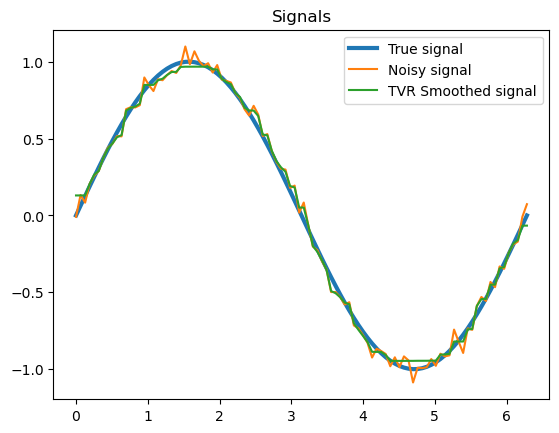

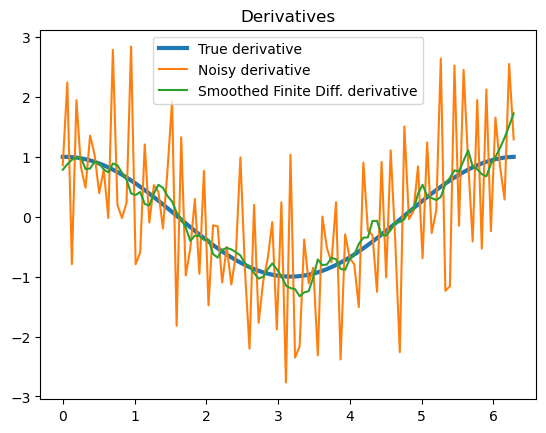

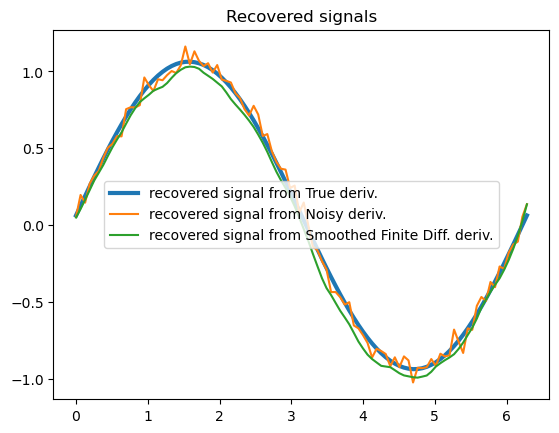

In [5]:
import numpy as np
from pysindy.differentiation import SmoothedFiniteDifference, SINDyDerivative
from scipy.optimize import minimize


def total_variation_regularization_smooth(x, t, alpha):
    """
    Total variation regularization for smoothing a multidimensional time series.

    Parameters:
        x (ndarray): The input time series to be smoothed (time, neurons).
        t (ndarray): The time vector corresponding to the input time series.
        alpha (float): The regularization parameter.

    Returns:
        ndarray: The smoothed time series.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    n, num_features = x.shape
    dt = np.diff(t)
    A = np.zeros((n - 1, n))
    for i in range(n - 1):
        A[i, i] = -1 / dt[i]
        A[i, i + 1] = 1 / dt[i]

    def objective(g):
        g = g.reshape(n, num_features)
        return np.sum((g - x) ** 2) + alpha * np.sum(np.abs(np.dot(A, g)))

    g0 = np.zeros((n, num_features))
    res = minimize(objective, g0.ravel(), method="L-BFGS-B")
    return res.x.reshape(n, num_features)


# Generate noisy data
t = np.linspace(0, 2 * np.pi, 100)
x_orig = np.sin(t)
x_noisy = x_orig + np.random.normal(scale=0.05, size=t.size)

# Use total variation regularization (TVR) to smooth the noisy data
x_smooth_tvr = total_variation_regularization_smooth(x_noisy, t, alpha=0.025)

# Compute the derivatives of the original and noisy data
dt = np.diff(t, prepend=t[0] - np.diff(t)[0])
dxdt_orig = np.diff(x_orig, prepend=x_orig[0] - np.diff(x_orig)[0]) / dt
dxdt_noisy = np.diff(x_noisy, prepend=x_orig[0] - np.diff(x_orig)[0]) / dt

# SINDy derivative
diff = SINDyDerivative()
dxdt_sindy = diff._differentiate(x_noisy, t)

# Smoothed finite difference derivative
diff = SmoothedFiniteDifference()
dxdt_findiff = diff._differentiate(x_noisy, t)

# Plot results
import matplotlib.pyplot as plt

# Plot the original, noisy, and TVR smoothed data
fig, ax = plt.subplots()
ax.plot(t, x_orig, label="True signal", linewidth=3)
ax.plot(t, x_noisy, label="Noisy signal")
ax.plot(t, x_smooth_tvr, label="TVR Smoothed signal")
ax.legend()
ax.set_title("Signals")
plt.show()

# Plot the different derivatives
fig, ax = plt.subplots()
ax.plot(t, dxdt_orig, label="True derivative", linewidth=3)
ax.plot(t, dxdt_noisy, label="Noisy derivative")
# ax.plot(t, dxdt_sindy, label="SINDy derivative")
ax.plot(t, dxdt_findiff, label="Smoothed Finite Diff. derivative")
ax.legend()
ax.set_title("Derivatives")
plt.show()

# Integrate to recover signal
fig, ax = plt.subplots()
ax.plot(
    t, np.cumsum(dxdt_orig) * dt, label="recovered signal from True deriv.", linewidth=3
)
ax.plot(t, np.cumsum(dxdt_noisy) * dt, label="recovered signal from Noisy deriv.")
# ax.plot(t, np.cumsum(dxdt_sindy) * dt, label="recovered SINDy signal")
ax.plot(
    t,
    np.cumsum(dxdt_findiff) * dt,
    label="recovered signal from Smoothed Finite Diff. deriv.",
)
ax.legend()
ax.set_title("Recovered signals")
plt.show()

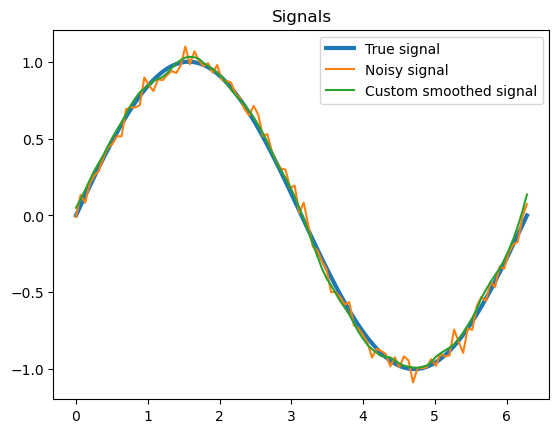

In [6]:
# Define a smoothing method that uses the Smoothed Finite Difference method
def finite_difference_smooth(x_, t_):
    """Uses the Smoothed Finite Difference derivative from PySINDy for smoothing.

    Parameters:
        x_ (ndarray): The input time series to be smoothed (time, neurons).
        t_ (ndarray): The time vector corresponding to the input time series.

    Returns:
        ndarray: The smoothed time series.
    """
    if x_.ndim == 1:
        x_ = x_.reshape(-1, 1)

    n, num_features = x_.shape
    dt = np.diff(t_, prepend=t_[0] - np.diff(t_)[0])
    diff = SmoothedFiniteDifference()

    x_smooth = np.zeros((n, num_features))
    for i in range(num_features):
        dxdt = diff._differentiate(x_[:, i], t_)
        x_smooth[:, i] = np.cumsum(dxdt) * dt

    return x_smooth


# Use the above method to smooth the noisy data
x_smooth_custom = finite_difference_smooth(x_noisy, t)

# Plot the original, noisy, and custom smoothed data
fig, ax = plt.subplots()
ax.plot(t, x_orig, label="True signal", linewidth=3)
ax.plot(t, x_noisy, label="Noisy signal")
ax.plot(t, x_smooth_custom, label="Custom smoothed signal")
ax.legend()
ax.set_title("Signals")
plt.show()


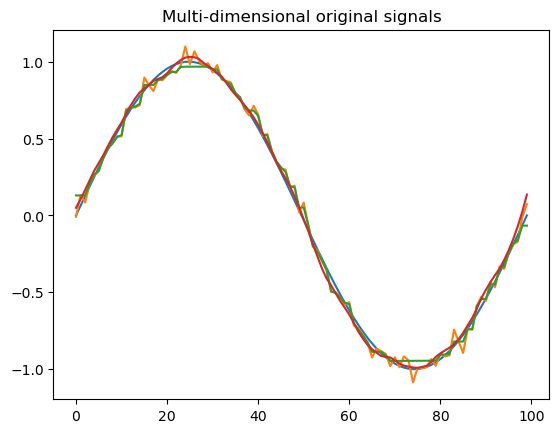

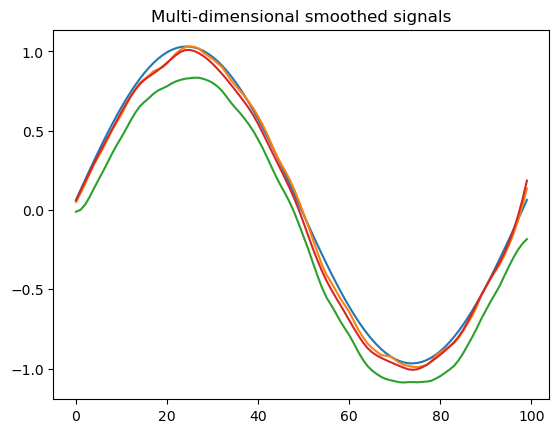

In [9]:
# Showing that the smoothing works on multidimensional data
X = np.stack(
    [x_orig, x_noisy, x_smooth_tvr.squeeze(), x_smooth_custom.squeeze()], axis=1
)
# X_smooth = total_variation_regularization_smooth(X, t, alpha=0.03)
X_smooth = finite_difference_smooth(X, t)
plt.plot(X)
plt.title("Multi-dimensional original signals")
plt.show()
plt.plot(X_smooth)
plt.title("Multi-dimensional smoothed signals")
plt.show()